## 6. Fitting and minimizing the data image by applying the nearest neighbour approach 


In Notebook 2, the data image with PSF was generated. In Notebook 5, the FOV is divided into sub-grids and the star-by-star or the 'nearest negihbour approach' is applied, where only the stars within the dispersive range of the concerned stars spectrum are considered in the analysis. A template 

The notebook is divided into the following sections:
1. Defining Input Parameters
2. Extracting information on the neighbouring population of stars for the concerned FOV
3. Demo for Fitting regions with n-stars (actual code ran on queenbee)
4. Accessing the accuracy of our technique for all 11 star regions
5. Plotting the accuracy as a function of the 'number of lowest chi-squared templates'
6. Understanding the resulting accuracy better

Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Nadine Neumayer and Francisco Nogueras-Lara (MPIA)** <br/>
Date: **30th November 2020** <br/>

In [1]:
import astropy.units as u
import astropy.io.fits as fits

import math
from scipy.sparse import csr_matrix
import scipy.stats as stats
import numpy as np
import os
import importlib

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# to show progress during computations
from time import sleep
import sys

import matplotlib
from mpl_toolkits import axes_grid1

# for doing combinatorics with spectra
from itertools import permutations
from more_itertools import distinct_permutations

import seaborn as sns

In [2]:
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import Simulating_Spectra as ss
import plotting as pt
import Slitless_spec_forward_modelling as ssfm
import star_by_star_template_library as stl
import Fitting_and_pdfs as fap

#### 01. Defining Input Parameters

In [4]:
# FOV in pixels
l_pix, u_pix = 0, 1128

# loads the effective FoV
x_pos, y_pos, mag_H, mag_Ks = np.load('Data/selected_FOV.npy')
selected_c_pxls = np.load('Data/selected_central_pixels.npy')

# directory paths
template_dir = 'Data/Stellar_template_library/'
save_data_crop_dir = 'Data/Cropped_Data_Images/'
save_data_psf_crop_dir = 'Data/Cropped_Data_PSF_Images/'
        
# set the dispersion range of the spectra
disperse_range = ss.defineDispersionRange(r=4000, lambda0=2.2, band_width=0.4)
print('The size of dispersion is set to be %d pixels'%disperse_range)

# effective FoV dimensions
u_pix_arr = [int(u_pix+disperse_range), u_pix]

dispersion_angle = 0 # degrees

# width of influence of the PSF on neighbouring stars (pixels)
width=3

# number to which the dimensions of the original image is reduced to cal chi-squared
num_splits = 5

# would you like to discard foreground stars completely or do something more complicated
discard_forground_stars = False
foreground_cutoff = 1.1

# discards background stars from the effective FoV
if discard_forground_stars:
    x_pos, y_pos, mag_H, mag_Ks = ssfm.discardForegroundStars(x_pos, y_pos, mag_H, mag_Ks, foreground_cutoff)
    num_stars = len(mag_Ks)

# start pixels of a small region of the sky
x_start, y_start = 0, 0

# start pixels in the original file
x_start_og, y_start_og = 1000, 2500

The size of dispersion is set to be 727 pixels


#### 2. Extracting information on the neighbouring population of stars for the concerned FOV

In [5]:
# these arrays that hold information about the location and number of neighbours
star_neighbours, num_neighbours, x_FOV, y_FOV = stl.findStarAndNeighbours(x_pos, y_pos, mag_H,\
                                                            mag_Ks, disperse_range,\
                                                            width, selected_c_pxls,\
                                                           [x_start, y_start], u_pix)

# arrays extract information about the no. of neighbours in total & outside FOV
neighbours_outside_FOV = np.array(num_neighbours[1])-np.array(num_neighbours[0])
total_neighbours = np.array(num_neighbours[1])

#### 3. Demo for Fitting regions with n-stars (actual code ran on queenbee)

In [ ]:
# model all regions with x neighbouring stars
n_stars_arr = [5, 6, 7, 9, 10]

# code fits templates for different pixel scales
for num_splits in [5]:
    print('Fitting for %d pixel scale'%num_splits)

    for n_stars in n_stars_arr:
        # define the limits of the region to be cropped
        limits = np.load(save_data_crop_dir + '%d_stars/limits.npy'%(n_stars))

        # associate spectra to those stars
        stars_with_n_neighbours = np.where(total_neighbours == n_stars)

        resulting_params_all = [] 

        for i, stars_idx in enumerate(stars_with_n_neighbours[0]):
            # arr to save the chi-sq val for a given hot star distribution, and the best template no. for this chi-sq
            save_all_chi_sqs, perms_lens = [], [] 
            resulting_params = np.zeros((0, 2))
            
            print('\nRegion %d of %d (%d stars):'%(i, len(stars_with_n_neighbours[0]), n_stars))
            
            # get positions and magnitudes of the neighbouring stars
            x, y, mKs = star_neighbours[1][stars_idx][0], star_neighbours[1][stars_idx][1], star_neighbours[1][stars_idx][3]
            
            data_mat_arr = fap.loadDataReduceResolution(n_stars, i, num_splits, limits, save_data_crop_dir, \
                                                        save_data_psf_crop_dir)
            # iterating over every possible hot star population
            for j, hot_stars in enumerate(hot_stars_arr): 
                print('%d percent hot stars -- '%(hot_stars*100))
                
                # generate 2D matricies from the template library by associating x, y and mKs to spectra
                perms = np.load(template_dir+'%d_stars/%d_hot_stars/perm_arr.npy'%(n_stars, hot_stars*n_stars)) 
                
                # iterating over all the permutations for the given hot star population
                chi_sq_vals, min_chi_sq,  best_fit_perm_no = fap.generateTemplatesCalChiSquare(x, y, mKs, template_dir, \
                                                                                               save_data_psf_crop_dir, n_stars, \
                                                                                               hot_stars, perms, disperse_range, \
                                                                                               dispersion_angle, u_pix_arr,\
                                                                                               limits[i], data_mat_arr, i,\
                                                                                               x_FOV[stars_idx], num_splits)
                
                save_all_chi_sqs.append(chi_sq_vals)
                resulting_params = np.append(resulting_params, [[min_chi_sq, best_fit_perm_no]], axis=0)
            
            # save the results of the computation for every region
            resulting_params_all.append(save_all_chi_sqs) 
            
        # save the best chi-square values for the given region
        np.save('Data/Chi_sq_vals/%d_stars_%d_regions_%d_pixel_scale.npy'%(n_stars, len(stars_with_n_neighbours[0]), num_splits), resulting_params_all)
    print('pixel scale: %d'%num_splits)

As we find all the best fitting templates, another important piece of info is to extract the stellar types of the stars for the regions in the defined 'data' image. The following code block prints the number of hot-stars simulating for each of the `n_star` neighbours.

In [7]:
for n_s in [5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]:
    
    # associate spectra to those stars
    stars_with_ns_neighbours = np.where(total_neighbours == n_s)

    stellar_types_data_arr, target_star_type, target_star_idx = stl.findStellarTypesDataStars(n_s, hot_stars_arr,\
                                                                                          stars_with_ns_neighbours,\
                                                                                          star_neighbours, x_pos,\
                                                                                          y_pos, x_FOV, y_FOV)
    print('There are %d hot target stars among the %d regions with %d stars i.e. %.2f percent'%(stl.countHotStars(target_star_type), len(target_star_type), n_s, stl.countHotStars(target_star_type)/len(target_star_type)))

There are 1 hot target stars among the 34 regions with 5 stars i.e. 0.03 percent
There are 4 hot target stars among the 60 regions with 6 stars i.e. 0.07 percent
There are 13 hot target stars among the 98 regions with 7 stars i.e. 0.13 percent
There are 18 hot target stars among the 147 regions with 8 stars i.e. 0.12 percent
There are 16 hot target stars among the 164 regions with 9 stars i.e. 0.10 percent
There are 22 hot target stars among the 182 regions with 10 stars i.e. 0.12 percent
There are 26 hot target stars among the 251 regions with 12 stars i.e. 0.10 percent
There are 29 hot target stars among the 281 regions with 13 stars i.e. 0.10 percent
There are 34 hot target stars among the 291 regions with 14 stars i.e. 0.12 percent
There are 25 hot target stars among the 324 regions with 15 stars i.e. 0.08 percent
There are 26 hot target stars among the 287 regions with 16 stars i.e. 0.09 percent


#### 4. Accessing the accuracy of our technique for all 11 star regions

In [55]:
n_stars = 11
pixel_scale = 3

hot_stars_arr = ssfm.generateHotStarArr(num_stars=n_stars)

stars_with_n_neighbours = np.where(total_neighbours == n_stars)

stellar_types_data_arr, target_star_type, target_star_idx = stl.findStellarTypesDataStars(n_stars, hot_stars_arr,\
                                                                                          stars_with_n_neighbours,\
                                                                                          star_neighbours, x_pos,\
                                                                                          y_pos, x_FOV, y_FOV)    

Loading the chi-squares for all regions and all templates with `n_stars`

In [56]:
resulting_params_all = np.load('Data/Stellar_chi_sq_vals/Fits/%d_stars_%d_regions_%d_pixel_scale.npy'%(n_stars, len(stars_with_n_neighbours[0]), pixel_scale), allow_pickle=True)

The following cell selects all the templates with chi-squares below a certain threshold value (defined by the chi-square cut)

/home/shreeram/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


The accuracy for 11 star regions is 57.65 %


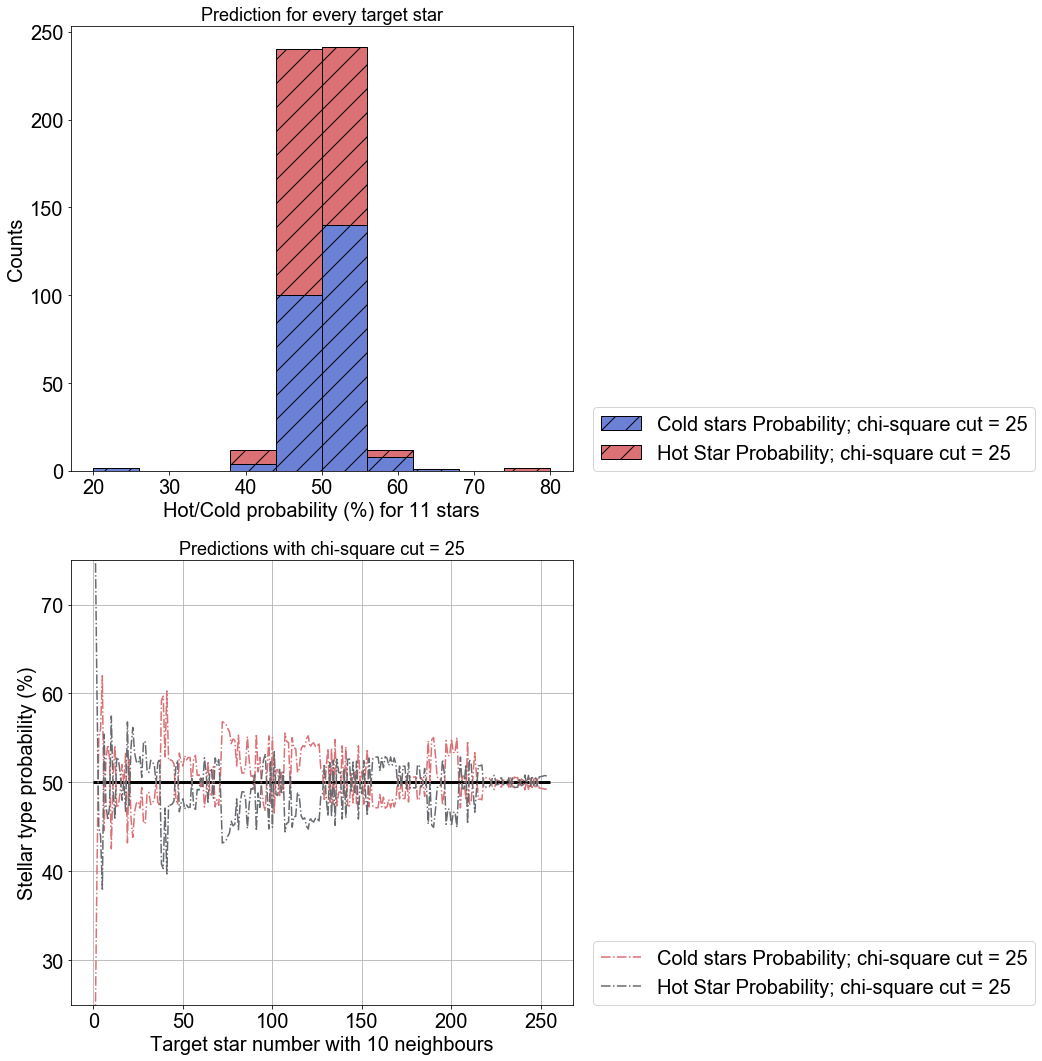

In [59]:
importlib.reload(stl)
accuracy_vals = []

hatch = ['/', '|', '+']
linestyle = ['-.', '-', ':']
num_temps_arr = [25]

fig, ax = plt.subplots(len(num_temps_arr)+1,1, figsize=(9,int(9*(1+len(num_temps_arr)))))

for j, param in enumerate(num_temps_arr):
    method = ['find_N_smallest_vals', param]
    
    hot_star_counts, target_star_prediction_all = stl.getTargetStarPrediction(hot_stars_arr, resulting_params_all,\
                                                                              stars_with_n_neighbours, template_dir, n_stars, \
                                                                              target_star_idx, print_msg=False, method=method)
    
    hot_probability, cold_probability = pt.plotTargetStarPrediction(ax[j], hot_star_counts, target_star_prediction_all,\
                                                                    hatch[j], method[1], n_stars, plot_fig=True)

    pt.plotChiSqPredictions(ax[j+1], cold_probability, hot_probability, linestyle[j], chi_sq_cut=param, n_stars=n_stars)

    accuracy = fap.evaluateAccuraryNstars(hot_probability, cold_probability, target_star_type)
    accuracy_vals.append(accuracy[0])
    
    print('The accuracy for %d star regions is %.2f %s'%(n_stars, accuracy_vals[0]*100, '%'))

Plot all the chi-squares for one of the `n_star` regions. This plot allows us to understand the basis of defining the selection cut for best-fitting templates.

There are 2048 number of total templates that were fitted to the region containing 11 stars


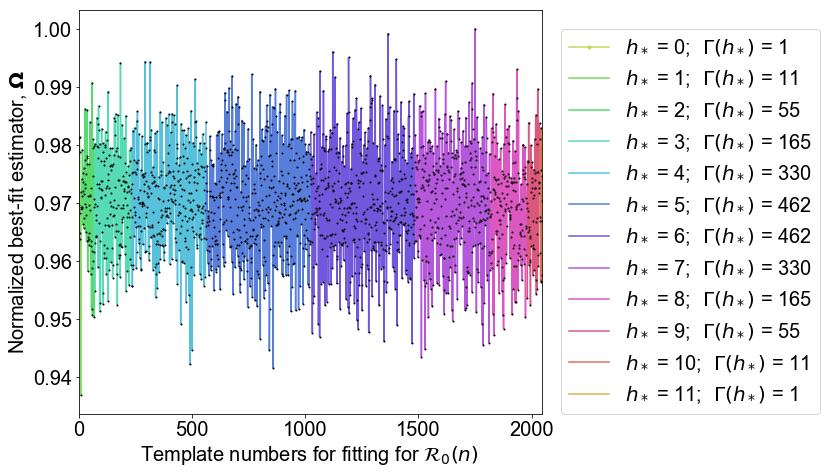

In [79]:
importlib.reload(pt)
importlib.reload(ssfm)
# define color palatte
pal = sns.hls_palette(len(hot_stars_arr), h=.2).as_hex()

fig, ax = plt.subplots(1,1, figsize=(12, 7))
pt.plotChiSqAllTemplates(ax, pal, resulting_params_all, hot_stars_arr, n_star = n_stars)

The following code cell is concerned only with the minimun chi-square template.

In [24]:
min_target_star_prediction_all = stl.getMinimumChiSqStarPrediction(resulting_params_all, template_dir, hot_stars_arr, \
                                                                   n_stars, stars_with_n_neighbours, target_star_idx)

count_good_stars = fap.checkAccuracyForMinChiSqTechnique(min_target_star_prediction_all, target_star_type)
print('Accuracy of the minimum chi-square only method: %.2f %s'%(count_good_stars*100/len(min_target_star_prediction_all), '%'))

Accuracy of the minimum chi-square only method: 49.02 %


#### 5. Plotting the accuracy as a function of the 'number of lowest chi-squared templates'

In [6]:
# x and y axis labels: analysis parameter optimization
n_star_arr = np.arange(5, 17)  
num_lowest_temps = [1, 5, 10, 12, 25, 50, 75, 100]#, 125, 150, 175]

# fitting parameter optimization
pixel_scale = [1, 3, 5, 7]

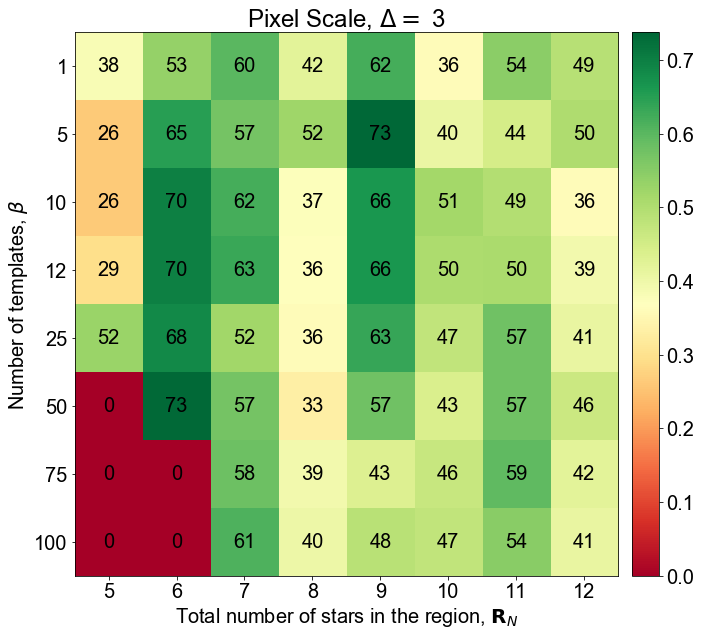

In [15]:
n_star_arr = np.arange(5, 13) 
acc_vals_arr = pt.plotAccuracyColormap(n_star_arr, num_lowest_temps, num_splits=3, colormap='RdYlGn', dir_name='Stellar_chi_sq_vals')

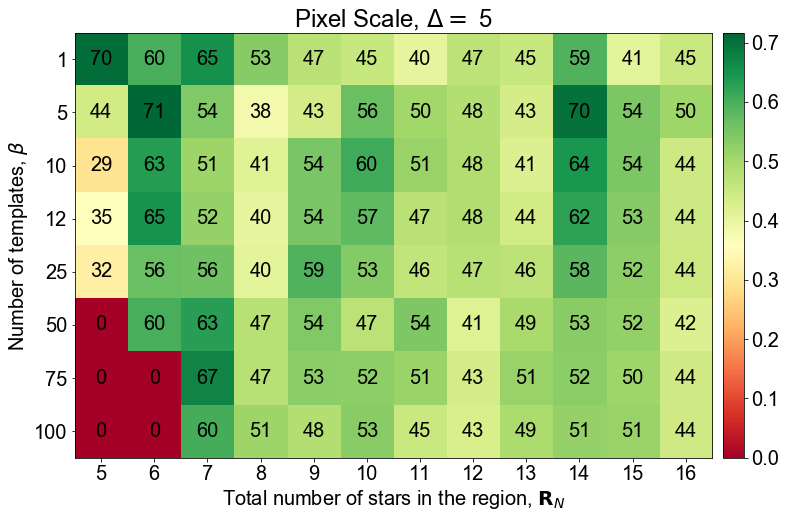

In [14]:
n_star_arr = np.arange(5, 17) 
acc_vals_arr = pt.plotAccuracyColormap(n_star_arr, num_lowest_temps, num_splits=5, colormap='RdYlGn')

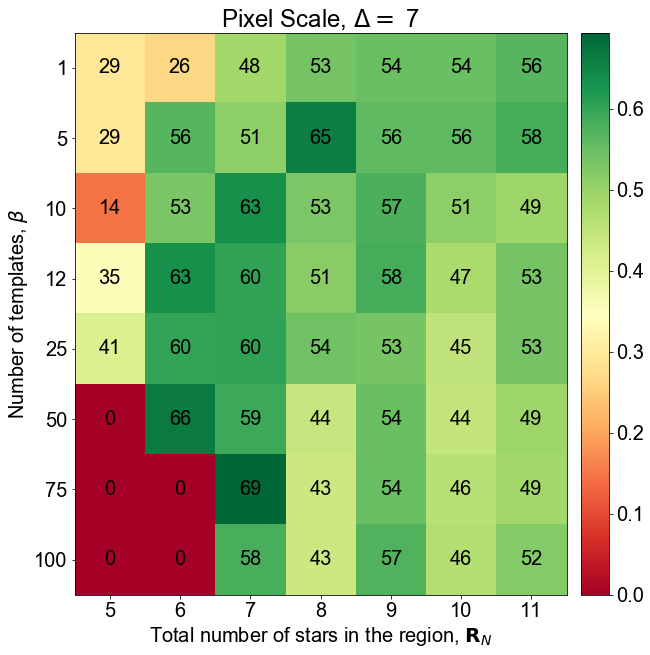

In [103]:
n_star_arr_new = np.arange(5, 12)  
acc_vals_arr = pt.plotAccuracyColormap(n_star_arr_new, num_lowest_temps, num_splits=7, colormap='RdYlGn')

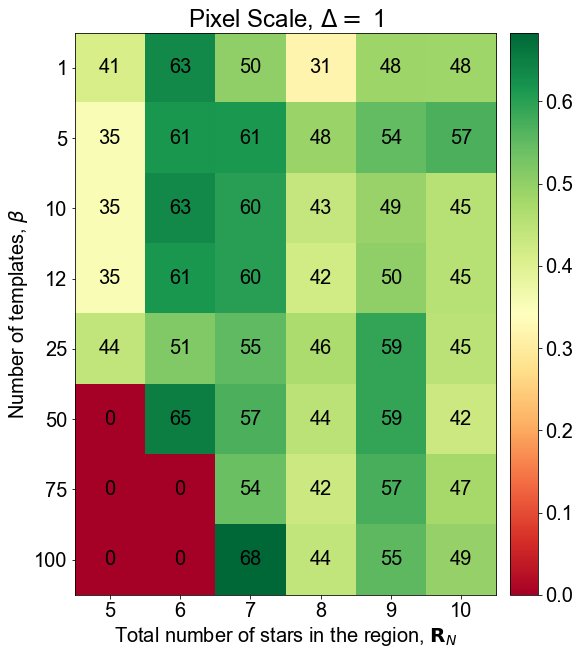

In [105]:
n_star_arr_new2 = np.arange(5, 11)  
acc_vals_arr = pt.plotAccuracyColormap(n_star_arr_new2, num_lowest_temps, num_splits=1, colormap='RdYlGn')

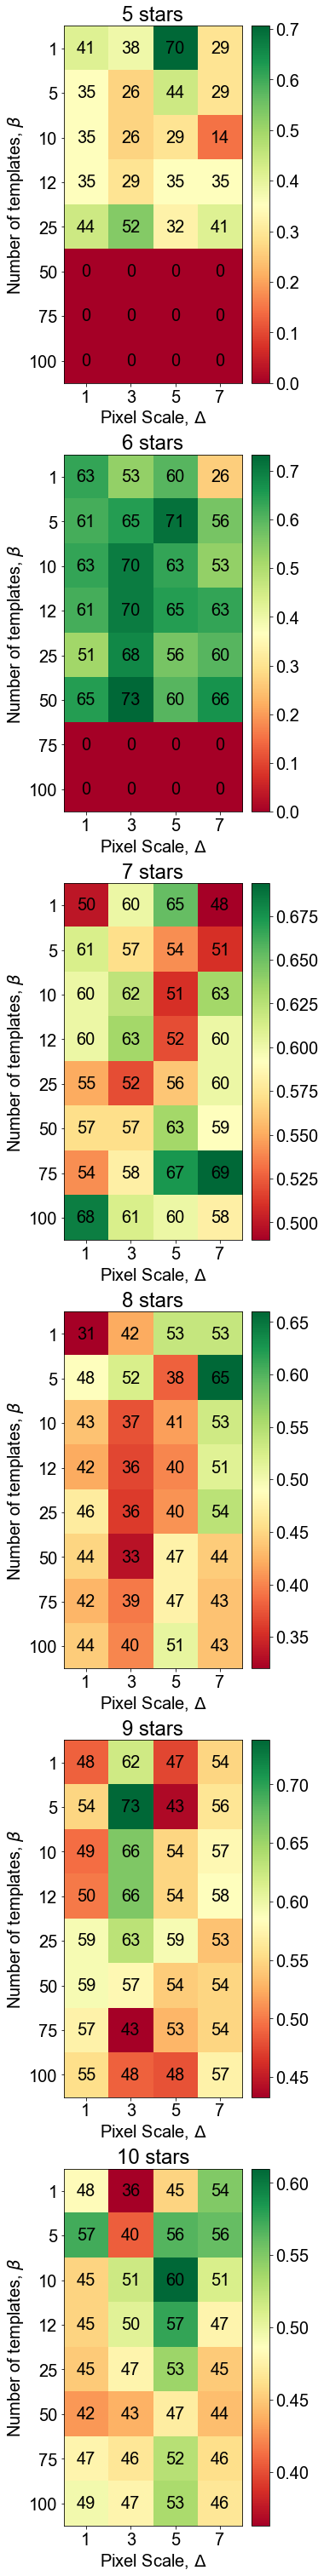

In [113]:
importlib.reload(pt)
pt.plotAccuracyPixelScale(pixel_scale, num_lowest_temps, n_star_arr=np.arange(5, 11), colormap='RdYlGn')

#### 6. Understanding the resulting accuracy better

We now wish to understand the effect of brightness of the neighbouring stars on the target star accuracy. One might expect that there is a high-level of uncetainty in predicting stellar types if there is a brighter star in the foreground/neighbourhood of the target star, resulting in poor prediction of the stellar type of the target star itself. Let's find this out in the following code block:

In [114]:
def compareBrightnessInRegions(stars_with_n_neighbours, target_star_idx):
    """
    Function to compare the brightness of neighbours with the target star
    """
    brighter_stars_by_region = []
    fore_stars_by_region = []
    
    for i, n_s in enumerate(stars_with_n_neighbours[0]):        
        # magnitudes of the stars in the region of interest
        mKs_n_stars = star_neighbours[1][n_s][2]
        mH_n_stars = star_neighbours[1][n_s][3]
        
        # target star idx in the region of interest
        idx = target_star_idx[i]
        
        # find how many of the neighbours are brighter than the target star
        mKs = np.delete(mKs_n_stars, idx)
        count_bright_stars = len(np.where(mKs<12.5)[0])
        brighter_stars_by_region.append(count_bright_stars)
                
        # find how many of the neighbours are foreground stars: H-K_s < 1.1
        count_fore_stars =  len( np.where( (mH_n_stars-mKs_n_stars)<1.1 )[0] )
        fore_stars_by_region.append(count_fore_stars)
    return brighter_stars_by_region, fore_stars_by_region

def saveAccuratePredicts(acc_array, brighter_stars_by_region):
    """
    
    """
    bright_stars = np.unique(brighter_stars_by_region)
    count_acc_stars_vs_bs = []
    
    for bs in bright_stars:
        idx = np.where(brighter_stars_by_region == bs)
        get_accuracies = acc_array[idx]
        
        count_accurate_stars = len(np.where(get_accuracies == 1)[0])
        count_acc_stars_vs_bs.append(count_accurate_stars)    
    return count_acc_stars_vs_bs, bright_stars

In [128]:
n_stars, num_splits = 11, 5

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

acc_vals = np.load('Data/Stellar_chi_sq_vals/%d_stars_accuracy_stars_%d_pixel_scale.npy'%(n_stars, num_splits), allow_pickle=True)
acc_array = np.array(acc_vals[0])
    
acc_pts = np.where(acc_array == 1)
#ax.plot(np.array(brighter_stars_by_region)[acc_pts[0]], np.array(cold_probability)[acc_pts[0]], 'g.', label='acccurate prediction')    
    
stars_with_n_neighbours = np.where(total_neighbours == n_stars)    
brighter_stars_by_region, fore_stars_by_region = compareBrightnessInRegions(stars_with_n_neighbours, target_star_idx)

count_acc_stars_vs_bs, bright_stars = saveAccuratePredicts(acc_array, brighter_stars_by_region) 
count_acc_stars_vs_fs, fore_stars = saveAccuratePredicts(acc_array, fore_stars_by_region) 

# top-left
bs, counts_bs = np.unique(brighter_stars_by_region, return_counts=True)
ax[0, 0].bar(bs, counts_bs , color=pal[9], align='center')    
ax[0, 0].plot(bright_stars , count_acc_stars_vs_bs, color='k', linestyle='--', marker='o', label='%d star regions'%n_stars)    

pt.setLabel(ax[0, 0], 'Brighter neighbours ($m_{Ks}<12.5$)', 'Accurately predicted target stars', '', 'default', 'default', legend=False)

# top-right
ax[0, 1].plot(bright_stars , (count_acc_stars_vs_bs/counts_bs)*100, color='r', linestyle='--', marker='s', label='%d star regions'%n_stars)    
pt.setLabel(ax[0, 1], 'Brighter neighbours ($m_{Ks}<12.5$)', 'Accurately predicted target stars %s'%('%'), '', 'default', 'default', legend=False)

# bottom-left
fs, counts_fs = np.unique(fore_stars_by_region, return_counts=True)
ax[1, 0].bar(fs, counts_fs , color=pal[6], align='center')    
ax[1, 0].plot(fore_stars , count_acc_stars_vs_fs, color='k', linestyle='--', marker='o', label='%d star regions'%n_stars)    

pt.setLabel(ax[1, 0], 'Foreground stars ($m_H-m_{Ks}<1.1$)', 'Accurately predicted target stars', '', 'default', 'default', legend=False)

# bottom-right
ax[1, 1].plot(fore_stars , (count_acc_stars_vs_fs/counts_fs)*100, color='r', linestyle='--', marker='s', label='%d star regions'%n_stars)    
pt.setLabel(ax[1, 1], 'Foreground stars ($m_H-m_{Ks}<1.1$)', 'Accurately predicted target stars %s'%('%'), '', 'default', 'default', legend=False)

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(9,8))
num_splits = 5
num_temps = np.where(num_lowest_temps == 5)[0]

for i, n_s in enumerate(np.arange(5, 13)):
    acc_vals = np.load('Data/Stellar_chi_sq_vals/%d_stars_accuracy_stars_%d_pixel_scale.npy'%(n_s, num_splits), allow_pickle=True)
    
    acc_array = np.array(acc_vals[num_temps])
    
    acc_pts = np.where(acc_array == 1)
    #ax.plot(np.array(brighter_stars_by_region)[acc_pts[0]], np.array(cold_probability)[acc_pts[0]], 'g.', label='acccurate prediction')    
    hot_stars_arr = ssfm.generateHotStarArr(num_stars=n_s)

    # associate spectra to those stars
    stars_with_ns_neighbours = np.where(total_neighbours == n_s)
    
    hot_stars_arr = ssfm.generateHotStarArr(num_stars=n_s)
    _, _, target_star_idx = stl.findStellarTypesDataStars(n_s, hot_stars_arr, stars_with_ns_neighbours,\
                                                          star_neighbours, x_pos, y_pos, x_FOV, y_FOV)
    
    brighter_stars_by_region, fore_stars_by_region = compareBrightnessInRegions(stars_with_n_neighbours, target_star_idx)
    count_acc_stars_vs_bs, bright_stars = saveAccuratePredicts(acc_array, brighter_stars_by_region) 
    
    ax.plot(bright_stars , count_acc_stars_vs_bs, color=pal[i], linestyle='--', marker='o', label='%d star regions'%n_s)    

pt.setLabel(ax, 'Number of brighter neighbours', 'Accurately predicted target stars', 'Accuracy as a function of bright neighbours', 'default', 'default', legend=True)
ax.grid(False)

### 8. Effects on accuracy due to changing the best-fit statistic


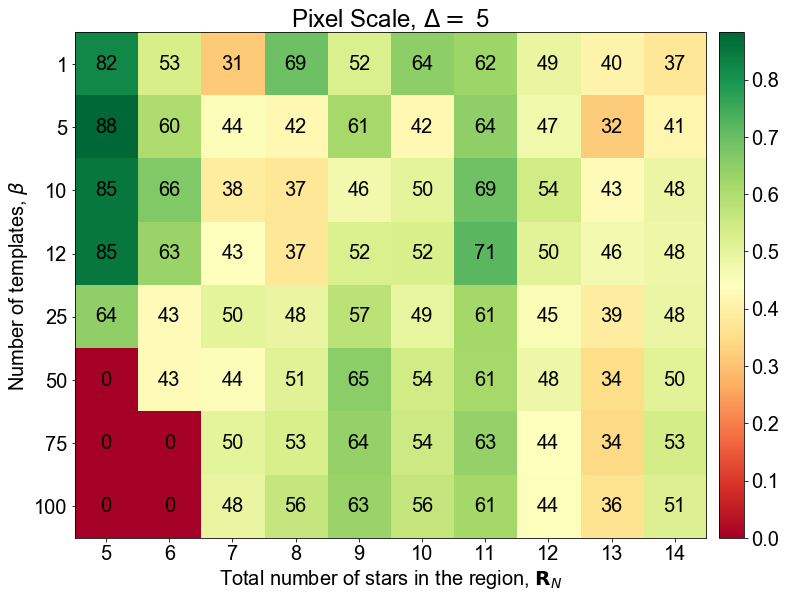

In [22]:
n_star_arr = np.arange(5, 15) 
acc_vals_arr = pt.plotAccuracyColormap(n_star_arr, num_lowest_temps, num_splits=5, colormap='RdYlGn', dir_name='Stellar_chi_sq_vals_with_changed_chi')

Residual between the two results

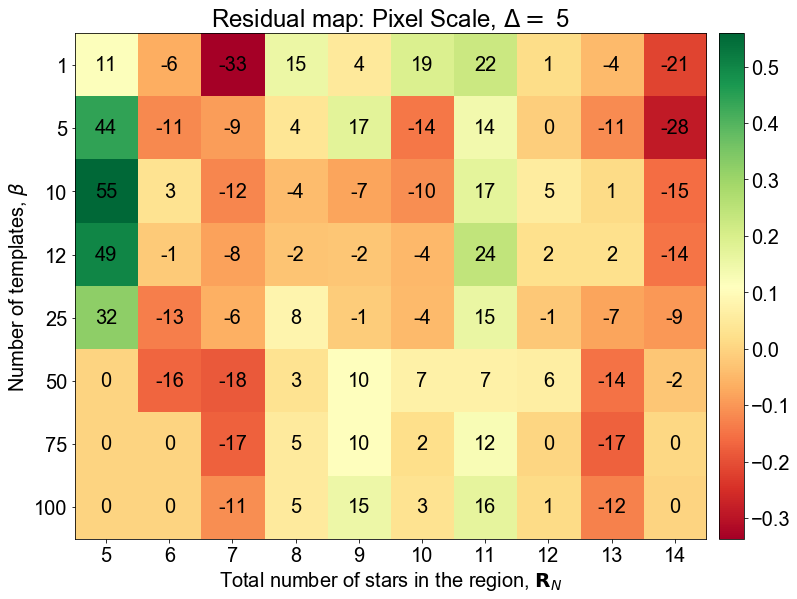

In [28]:
n_star_arr = np.arange(5, 15) 
dir_name = ['Stellar_chi_sq_vals', 'Stellar_chi_sq_vals_with_changed_chi']
_= pt.plotAccuracyResidualColormap(n_star_arr, num_lowest_temps, num_splits=5, colormap='RdYlGn', dir_name=dir_name)